<h1 align=center><font size = 5>Italian cooking: looking for an interesting neighborhood to offer a cooking course</font></h1>
<img src = "https://www.giallozafferano.it/images/ricette/206/20605/foto_hd/hd450x300.jpg" width = 400>

## Introduction

In this project I will supose I work for a cooking teaching company. We are interested in giving a course about cooking an Italian dessert: Sicilian Canolo. We will focus on giving 5 courses in Manhattan, New York, and we will look for neighborhood with the most quantity of Italian restaurants, Pizza places and cafeterias, because we think that there may be candidates to take the course.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

We first load the libraries we need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    scipy-1.4.1                |   py36h921218d_0        18.9 MB  conda-forge
    lib

<a id='item1'></a>

## 1. Download and Explore Dataset

Database will be download from:

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


Next, let's load the data.

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [4]:
#newyork_data     #uncomment to check. It is a long output so I added a short sample:

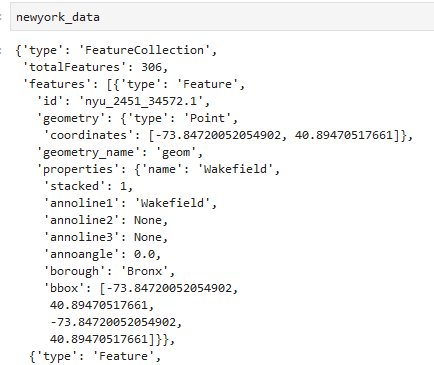

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [4]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

First, we will create a dataframe and then we will fill it with the data.

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [7]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Let's check it:

In [9]:
neighborhoods.tail()

,Borough,Neighborhood,Latitude,Longitude
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631
305,Staten Island,Fox Hills,40.617311,-74.081740


#### We will use geopy to get the latitude and longitude values of New York City.

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### We will first have a look to the neighborhoods on the map:

In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

We will just serach on Manhattan for these courses:

In [12]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [13]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


As we did with all of New York City, let's visualizat Manhattan the neighborhoods in it.

In [14]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Now we will serach for venues in FourSquare.

#### Define Foursquare Credentials and Version

In [15]:
CLIENT_ID = 'FBDOICUESCR2GFHGCP0HBY41WH4ZTCHT0RUTWMZKVDSDZDZE' # your Foursquare ID
CLIENT_SECRET = 'FYA2TX4Z0ZCDGUSMUO53PBJ2H1LQIUU0KEV4ODO5RBCL0CA3' # your Foursquare Secret
VERSION = '20180604'

In [17]:
manhattan_data.loc[4, 'Neighborhood']

'Hamilton Heights'

Get the neighborhood's latitude and longitude values.

In [18]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [19]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=FBDOICUESCR2GFHGCP0HBY41WH4ZTCHT0RUTWMZKVDSDZDZE&client_secret=FYA2TX4Z0ZCDGUSMUO53PBJ2H1LQIUU0KEV4ODO5RBCL0CA3&v=20180604&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

Send the GET request and examine the resutls

In [20]:
results = requests.get(url).json()
#results      #uncomment to check

Let's define the function we will use later:

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues. head()

,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Starbucks,Coffee Shop,40.877531,-73.905582
4,Dunkin',Donut Shop,40.877136,-73.906666


I need to get just the Italian Restaurants and Pizza Places:

In [23]:
It_Restaurants=nearby_venues.loc[nearby_venues['categories'] == 'Italian Restaurant']
Pizza_Places= nearby_venues.loc[nearby_venues['categories'] == 'Pizza Place']
frames = [It_Restaurants, Pizza_Places]
venues = pd.concat(frames)
venues.tail()

,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271


<a id='item2'></a>

## 2. Explore Neighborhoods in Manhattan

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan in order to find the one with the most Italian Restaurants and cafaterias interested in learning the Canolo recipy:

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called manhattan_venues

In [25]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


#### Let's check the size of the resulting dataframe

In [26]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3293, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [27]:
It_Restaurants=manhattan_venues.loc[manhattan_venues['Venue Category'] == 'Italian Restaurant']
Pizza_Places= manhattan_venues.loc[manhattan_venues['Venue Category'] == 'Pizza Place']
frames = [It_Restaurants, Pizza_Places]
venues = pd.concat(frames)
venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2982,Turtle Bay,40.752042,-73.967708,Patsy's Pizzeria,40.750285,-73.971931,Pizza Place
3032,Tudor City,40.746917,-73.971219,Garlic New York Pizza Bar,40.745068,-73.975666,Pizza Place
3040,Tudor City,40.746917,-73.971219,Patsy's Pizzeria,40.750285,-73.971931,Pizza Place
3084,Tudor City,40.746917,-73.971219,Royal Pizza,40.748807,-73.975906,Pizza Place
3089,Tudor City,40.746917,-73.971219,Libretto's Pizzeria,40.747196,-73.977089,Pizza Place


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [28]:
Manhattan_venues=venues

# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.tail()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Sh

We just want to keep venues that may be interested in the Canolo Making Course

In [29]:
moneh=manhattan_onehot[['Neighborhood','Cafeteria','Café','Coffee Shop','Creperie','Italian Restaurant','Pizza Place']]
moneh.tail()

,Neighborhood,Cafeteria,Café,Coffee Shop,Creperie,Italian Restaurant,Pizza Place
3288,Hudson Yards,0,0,0,0,0,0
3289,Hudson Yards,0,0,0,0,0,0
3290,Hudson Yards,0,0,0,0,0,0
3291,Hudson Yards,0,1,0,0,0,0
3292,Hudson Yards,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [30]:
manhattan_grouped = moneh.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Cafeteria,Café,Coffee Shop,Creperie,Italian Restaurant,Pizza Place
0,Battery Park City,0.000000,0.000000,0.052632,0.00,0.021053,0.021053
1,Carnegie Hill,0.000000,0.030000,0.070000,0.00,0.020000,0.060000
2,Central Harlem,0.021277,0.021277,0.000000,0.00,0.000000,0.021277
3,Chelsea,0.000000,0.010000,0.060000,0.01,0.040000,0.010000
4,Chinatown,0.000000,0.000000,0.020000,0.00,0.010000,0.010000
5,Civic Center,0.000000,0.020000,0.040000,0.00,0.040000,0.000000
6,Clinton,0.000000,0.010000,0.050000,0.00,0.050000,0.010000
7,East Harlem,0.000000,0.025641,0.000000,0.00,0.000000,0.025641
8,East Village,0.000000,0.000000,0.030000,0.00,0.030000,0.040000
9,Financial District,0.000000,0.020000,0.100000,0.00,0.020000,0.040000


#### Let's confirm the new size

In [31]:
manhattan_grouped.shape

(40, 7)

#### Let's print each neighborhood along with the top 5 most common venues

In [32]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                venue  freq
0         Coffee Shop  0.05
1  Italian Restaurant  0.02
2         Pizza Place  0.02
3           Cafeteria  0.00
4                Café  0.00


----Carnegie Hill----
                venue  freq
0         Coffee Shop  0.07
1         Pizza Place  0.06
2                Café  0.03
3  Italian Restaurant  0.02
4           Cafeteria  0.00


----Central Harlem----
         venue  freq
0    Cafeteria  0.02
1         Café  0.02
2  Pizza Place  0.02
3  Coffee Shop  0.00
4     Creperie  0.00


----Chelsea----
                venue  freq
0         Coffee Shop  0.06
1  Italian Restaurant  0.04
2                Café  0.01
3            Creperie  0.01
4         Pizza Place  0.01


----Chinatown----
                venue  freq
0         Coffee Shop  0.02
1  Italian Restaurant  0.01
2         Pizza Place  0.01
3           Cafeteria  0.00
4                Café  0.00


----Civic Center----
                venue  freq
0         Coffee Shop  0.04
1  Italian

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [34]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Coffee Shop,Pizza Place,Italian Restaurant,Creperie,Café
1,Carnegie Hill,Coffee Shop,Pizza Place,Café,Italian Restaurant,Creperie
2,Central Harlem,Pizza Place,Café,Cafeteria,Italian Restaurant,Creperie
3,Chelsea,Coffee Shop,Italian Restaurant,Pizza Place,Creperie,Café
4,Chinatown,Coffee Shop,Pizza Place,Italian Restaurant,Creperie,Café


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [35]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 3, 4, 3, 4, 4, 3, 3, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [36]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Coffee Shop,Pizza Place,Italian Restaurant,Creperie,Café
1,Manhattan,Chinatown,40.715618,-73.994279,3,Coffee Shop,Pizza Place,Italian Restaurant,Creperie,Café
2,Manhattan,Washington Heights,40.851903,-73.936900,2,Café,Coffee Shop,Pizza Place,Italian Restaurant,Creperie
3,Manhattan,Inwood,40.867684,-73.921210,2,Café,Pizza Place,Coffee Shop,Italian Restaurant,Creperie
4,Manhattan,Hamilton Heights,40.823604,-73.949688,2,Pizza Place,Coffee Shop,Café,Italian Restaurant,Creperie


In [37]:
venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2982,Turtle Bay,40.752042,-73.967708,Patsy's Pizzeria,40.750285,-73.971931,Pizza Place
3032,Tudor City,40.746917,-73.971219,Garlic New York Pizza Bar,40.745068,-73.975666,Pizza Place
3040,Tudor City,40.746917,-73.971219,Patsy's Pizzeria,40.750285,-73.971931,Pizza Place
3084,Tudor City,40.746917,-73.971219,Royal Pizza,40.748807,-73.975906,Pizza Place
3089,Tudor City,40.746917,-73.971219,Libretto's Pizzeria,40.747196,-73.977089,Pizza Place


In [38]:
# create map
map_venues2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, in zip(venues['Venue Latitude'], venues['Venue Longitude'], venues['Neighborhood'] ):
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    #    popup=label,
    color='blue',  #rainbow[cluster-1],
    fill=True,
    fill_color='cian', #rainbow[cluster-1],
    fill_opacity=0.7).add_to(map_venues2)
map_venues2

In [39]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 3, 4, 3, 4, 4, 3, 3, 1], dtype=int32)

In [40]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)   #uncomment if firt time

manhattan_merged = manhattan_data

# merge  to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Coffee Shop,Pizza Place,Italian Restaurant,Creperie,Café
1,Manhattan,Chinatown,40.715618,-73.994279,3,Coffee Shop,Pizza Place,Italian Restaurant,Creperie,Café
2,Manhattan,Washington Heights,40.851903,-73.936900,2,Café,Coffee Shop,Pizza Place,Italian Restaurant,Creperie
3,Manhattan,Inwood,40.867684,-73.921210,2,Café,Pizza Place,Coffee Shop,Italian Restaurant,Creperie
4,Manhattan,Hamilton Heights,40.823604,-73.949688,2,Pizza Place,Coffee Shop,Café,Italian Restaurant,Creperie


Finally, let's visualize the resulting clusters

In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

#### Cluster 1

In [42]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Lincoln Square,Italian Restaurant,Café,Coffee Shop,Pizza Place,Creperie
18,Greenwich Village,Italian Restaurant,Café,Coffee Shop,Pizza Place,Creperie
21,Tribeca,Italian Restaurant,Café,Coffee Shop,Pizza Place,Creperie
22,Little Italy,Italian Restaurant,Café,Pizza Place,Coffee Shop,Creperie
39,Hudson Yards,Italian Restaurant,Café,Coffee Shop,Pizza Place,Creperie


#### Cluster 2

In [43]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Marble Hill,Coffee Shop,Pizza Place,Italian Restaurant,Creperie,Café
11,Roosevelt Island,Coffee Shop,Pizza Place,Italian Restaurant,Creperie,Café
25,Manhattan Valley,Coffee Shop,Pizza Place,Italian Restaurant,Café,Creperie
26,Morningside Heights,Coffee Shop,Pizza Place,Café,Italian Restaurant,Creperie
29,Financial District,Coffee Shop,Pizza Place,Italian Restaurant,Café,Creperie
30,Carnegie Hill,Coffee Shop,Pizza Place,Café,Italian Restaurant,Creperie


#### Cluster 3

In [44]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Washington Heights,Café,Coffee Shop,Pizza Place,Italian Restaurant,Creperie
3,Inwood,Café,Pizza Place,Coffee Shop,Italian Restaurant,Creperie
4,Hamilton Heights,Pizza Place,Coffee Shop,Café,Italian Restaurant,Creperie
20,Lower East Side,Pizza Place,Coffee Shop,Café,Italian Restaurant,Creperie
36,Tudor City,Café,Pizza Place,Coffee Shop,Italian Restaurant,Creperie


#### Cluster 4

In [45]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Chinatown,Coffee Shop,Pizza Place,Italian Restaurant,Creperie,Café
6,Central Harlem,Pizza Place,Café,Cafeteria,Italian Restaurant,Creperie
7,East Harlem,Pizza Place,Café,Italian Restaurant,Creperie,Coffee Shop
15,Midtown,Coffee Shop,Café,Pizza Place,Italian Restaurant,Creperie
19,East Village,Pizza Place,Italian Restaurant,Coffee Shop,Creperie,Café
23,Soho,Italian Restaurant,Pizza Place,Coffee Shop,Café,Creperie
28,Battery Park City,Coffee Shop,Pizza Place,Italian Restaurant,Creperie,Café
33,Midtown South,Coffee Shop,Italian Restaurant,Café,Pizza Place,Creperie
37,Stuyvesant Town,Coffee Shop,Pizza Place,Italian Restaurant,Creperie,Café
38,Flatiron,Café,Coffee Shop,Italian Restaurant,Pizza Place,Creperie


#### Cluster 5

In [46]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Manhattanville,Coffee Shop,Italian Restaurant,Café,Pizza Place,Creperie
8,Upper East Side,Italian Restaurant,Coffee Shop,Pizza Place,Creperie,Café
9,Yorkville,Italian Restaurant,Coffee Shop,Pizza Place,Café,Creperie
10,Lenox Hill,Italian Restaurant,Coffee Shop,Pizza Place,Café,Creperie
12,Upper West Side,Italian Restaurant,Coffee Shop,Café,Pizza Place,Creperie
14,Clinton,Italian Restaurant,Coffee Shop,Pizza Place,Café,Creperie
16,Murray Hill,Coffee Shop,Italian Restaurant,Pizza Place,Café,Creperie
17,Chelsea,Coffee Shop,Italian Restaurant,Pizza Place,Creperie,Café
24,West Village,Italian Restaurant,Coffee Shop,Pizza Place,Café,Creperie
27,Gramercy,Italian Restaurant,Pizza Place,Coffee Shop,Café,Creperie


In [47]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
71,Chinatown,40.715618,-73.994279,Bacaro,40.714468,-73.991589,Italian Restaurant
126,Washington Heights,40.851903,-73.936900,Saggio Restaurant,40.851423,-73.939761,Italian Restaurant
267,Hamilton Heights,40.823604,-73.949688,Fumo,40.821412,-73.950499,Italian Restaurant
329,Manhattanville,40.816934,-73.957385,Pisticci Ristorante,40.814015,-73.960266,Italian Restaurant
337,Manhattanville,40.816934,-73.957385,Bettolona,40.814084,-73.959574,Italian Restaurant


In [48]:
def f(row):
    if row['Neighborhood'] == "Chinatown":
        val = 1
    elif row['Neighborhood'] == "Washington Heights":
        val = 2
    elif row['Neighborhood'] == "Hamilton Heights":
        val = 3
    elif row['Neighborhood'] == "Manhattanville":
        val = 4
    elif row['Neighborhood'] == "Upper East Side":
        val = 5
    elif row['Neighborhood'] == "Yorkville":
        val = 6
    elif row['Neighborhood'] == "Lenox Hill ":
        val = 7
    elif row['Neighborhood'] == "Lincoln Square":
        val = 8
    elif row['Neighborhood'] == "Upper West Side":
        val = 9
    elif row['Neighborhood'] == "Chelsea":
        val = 10
    elif row['Neighborhood'] == "Clinton":
        val = 11
    elif row['Neighborhood'] == "Greenwich Village":
        val = 12
    elif row['Neighborhood'] == "Upper West Side":
        val = 13
    else:
        val = 0
    return val

venues['Cluster'] = venues.apply(f, axis=1)
#venues['Cluster']= venues['Neighborhood'].apply(lambda x: 2 if  venues['Neighborhood'].items == "Chinatown" else 0)

In [49]:
venuest=venues
venuest=venuest.drop(columns=['Neighborhood Latitude', 'Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category'])

In [50]:
venuest=venuest.rename(columns={"Cluster": "T"})
venuest = venuest.groupby('Neighborhood')
venuest.count()

,T
Neighborhood,
Battery Park City,4
Carnegie Hill,8
Central Harlem,1
Chelsea,5
Chinatown,2
Civic Center,4
Clinton,6
East Harlem,1
East Village,7


In [51]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster
71,Chinatown,40.715618,-73.994279,Bacaro,40.714468,-73.991589,Italian Restaurant,1
126,Washington Heights,40.851903,-73.936900,Saggio Restaurant,40.851423,-73.939761,Italian Restaurant,2
267,Hamilton Heights,40.823604,-73.949688,Fumo,40.821412,-73.950499,Italian Restaurant,3
329,Manhattanville,40.816934,-73.957385,Pisticci Ristorante,40.814015,-73.960266,Italian Restaurant,4
337,Manhattanville,40.816934,-73.957385,Bettolona,40.814084,-73.959574,Italian Restaurant,4


In [52]:
c1=venues.loc[venues['Neighborhood'] == 'Greenwich Village']
c2=venues.loc[venues['Neighborhood'] == 'Yorkville']
c3=venues.loc[venues['Neighborhood'] == 'West Village']
c4=venues.loc[venues['Neighborhood'] == 'Noho']
c5=venues.loc[venues['Neighborhood'] == 'Gramercy']
frames = [c1,c2,c3,c4,c5]
venues5 = pd.concat(frames)
venues5.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster
2198,Gramercy,40.73721,-73.981376,Coppola's,40.741572,-73.981356,Italian Restaurant,0
2131,Gramercy,40.73721,-73.981376,Posto,40.734737,-73.983049,Pizza Place,0
2133,Gramercy,40.73721,-73.981376,Lunetta Pizza,40.736934,-73.984489,Pizza Place,0
2135,Gramercy,40.73721,-73.981376,Frank's Trattoria,40.736031,-73.979160,Pizza Place,0
2187,Gramercy,40.73721,-73.981376,La Vera Pizzeria,40.740574,-73.981948,Pizza Place,0


In [53]:
def f(row):
    if row['Neighborhood'] == "Greenwich Village":
        val = 1
    elif row['Neighborhood'] == "Yorkville":
        val = 2
    elif row['Neighborhood'] == "West Village":
        val = 3
    elif row['Neighborhood'] == "Noho":
        val = 4
    else:
        val = 0
    return val

venues5['Cluster'] = venues5.apply(f, axis=1)

In [54]:
# create map
map_clusters5 = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters=5
# set color scheme for the clusters
x = np.arange(kclusters) 
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues5['Venue Latitude'], venues5['Venue Longitude'], venues5['Neighborhood'], venues5['Cluster'] ):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters5)
map_clusters5


In the map are shown the Italian restaurants, coffee shops, cafeterias, pizza places and cafes. Those are the neighborhoods where there is high density of venues where cooks can be interested in taking the italian dessert cooking course, "Italian Sicilian Canolo". 
So we found what we were looking for: the 5 more interesting neighborhoods to offer the course were found.

### Thank you for viewing!

<hr>